In [9]:
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
import os

def pool(mask, image, fn, kernel=5, stride=2):
    h_prev, w_prev = mask.shape

    labels = []
    values = []
    xs = []
    ys = []

    curr_y = out_y = 0
    # slide the max pooling window vertically across the image
    while curr_y + kernel <= h_prev:
        curr_x = out_x = 0
        # slide the max pooling window horizontally across the image
        while curr_x + kernel <= w_prev:
            # choose the maximum value within the window at each step and store it to   the output matrix

            if fn(mask[curr_y:curr_y + kernel, curr_x:curr_x + kernel]):
                labels.append(0)
            else:
                labels.append(1)

            values.append(np.ravel(image[curr_y:curr_y + kernel, curr_x:curr_x + kernel, :]))
            ys.append((curr_y+curr_y + kernel)//2)
            xs.append((curr_x+curr_x+kernel)//2)
            curr_x += stride
            out_x += 1
        curr_y += stride
        out_y += 1

    return (labels, values, xs, ys)

def edge(img):
    return np.sum(img) >= 0




In [46]:
file_arr = [filename for filename in os.listdir('images/unmarked/masks/')]
X = []
y = []

for i in trange(len(file_arr)):
    name = file_arr[i]
    im = Image.open('images/unmarked/masks/'+name)
    size = im.getdata().size
    img = np.array(im.getdata()).reshape((size[1],size[0],3))
    img = img[:,:,0]
    img[img>0] = 1
    img[img<=0] = -1

    im2 = Image.open('images/unmarked/train_cnn/'+name)
    img2 = np.array(im2.getdata()).reshape((size[1],size[0],3))
    
    (labels, values, xs, ys) = pool(img, img2, edge, 40, 20)
    X += values
    y += labels


100%|██████████| 19/19 [00:42<00:00,  2.31s/it]


In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
X = normalize(X)

In [52]:
clf = MLPClassifier(hidden_layer_sizes=(2,)).fit(X,y)

In [55]:
sum(clf.predict(X))

0

100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


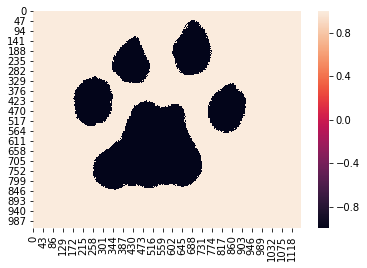

In [54]:
for i in trange(1,2):
    name = file_arr[i]
    im = Image.open('images/unmarked/masks/'+name)
    size = im.getdata().size
    img = np.array(im.getdata()).reshape((size[1],size[0],3))
    img = img[:,:,0]
    img[img>0] = 1
    img[img<=0] = -1

    im2 = Image.open('images/unmarked/train_cnn/'+name)
    img2 = np.array(im2.getdata()).reshape((size[1],size[0],3))
    
    (labels, values, xs, ys) = pool(img, img2, edge, 40, 20)
    
scatterlist_x = []
scatterlist_y = []
predictions = clf.predict(values)
for i in range(len(values)):
    if predictions[i] == 1:
        scatterlist_x.append(xs[i])
        scatterlist_y.append(ys[i])
sns.heatmap(img)
plt.scatter(scatterlist_x, scatterlist_y, c='r')